# RBM (Restrictive Boltzmann Machine)

> Assigns lower energy values to more relevant features and higher energy values for less important features.

> **Objective**: minimize the energy value.

> **Restrictive**: because the neurons inside the same layer are not connected, but they are fully connected with the neurons in the next layer.

### Gibbs Sampling
The learning process consists of 2 phases:
- Gibbs sampling: first, the input (v) data is sent through the visible layer (forward pass), then the states of the neurons in the hidden layer are computed (h). Based on the obtained hidden layer values, it predicts the new input values for the visible layer (backward pass).
- Contrastive Divergence: update weights based on the inputs to visible layers and the activation probabilities for the hidden layers.

To find the optimal weight W, which minimizes the energy function E (cost function), we use **SGD**(Stochastic Gradient Descent) algorithm. For this we need to compute the derivative of E with respect to v and h (visible and hidden neuron's input), which in turn gives us 2 terms, a positive and negative gradient.
Positive phase increases the probability of the training data, while the negative decreases it.

To adjust the weights we use the "Contrastive Divergence" algorithm, which build an update matrix that allows to alter incrementally the value of W.
W_new = W + learning_rate * CD

The RBM is trained through several forward and backward passes until it is able to extract the most important features/patterns.
> * **Forward pass**: input processing
> * **Backward pass**: reconstruction

### Energy based model
Computes the free energy for the initial input to the visible layer and the reconstructed input, then it defines the loss as the absolute difference between these energy values.
> **Free energy** is the energy that a single configuration would need in order to
    have the same probability as all configurations containing v


In [222]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow_datasets as tfds
import cv2
import random
from PIL import Image
import os

In [223]:
# test if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.experimental.get_device_details(physical_devices[0]))
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
GPU_NAME = logical_devices[0].name
print("logical GPU name = ", GPU_NAME)

{'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
logical GPU name =  /device:GPU:0


In [224]:
class RBM:
    def __init__(self, nv, nh, W=None, hb=None, vb=None, k=1, model_type=0):
        """"
        :param nv = nr of neurons in the visible layer
        :param nh = nr of neurons in the hidden layer
        :param k = nr of times to perform Gibbs sampling
        :param model_type: 0 for the Gibbs sampling and 1 for Energy based model
        """""
        self.nv = nv
        self.nh = nh
        self.k = k
        self.model_type = model_type

        # initialize the weight matrix
        self.W = W if W else tf.Variable(tf.random.normal([self.nv, self.nh]))
        # bias for hidden layer (initialized with 0)
        self.hb = hb if hb else tf.Variable(np.zeros(self.nh).astype(np.float32))
        # bias for visible layer (initialized with 0)
        self.vb = vb if vb else tf.Variable(np.zeros(self.nv).astype(np.float32))

    def bernoulli(self, p):
        return tf.nn.relu(tf.sign(p - tf.random.uniform(tf.shape(p))))

    def forward_pass(self, v):
        """
         forward pass: compute a sample hidden activation vector (h)
        """
        h_p = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hb)
        # recompute sample based on the probability of the hidden layer
        h_s = self.bernoulli(h_p)
        return h_p, h_s

    def backward_pass(self, h):
        """
         backward pass: compute a sample visible activation vector (v)
        """
        v_p = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.vb)
        # recompute sample based on the probability of the visible layer
        v_s = self.bernoulli(v_p)
        return v_p, v_s

    def reconstruct(self, v0):
        """
        Represent a forward & backward pass through the network.
        Return the reconstructed image based on the previously learned weights.
        """
        # flatten the input into a 1D array
        original_shape = v0.shape
        v0 = np.reshape(v0, (1, -1))
        v0 = v0 / 255.0
        # initial hidden prob vector based on the input v0
        h0_p, h0_s = self.forward_pass(v0)
        # reconstruct the input
        v1_p, v1_s = self.backward_pass(h0_s)
        # convert the output to the input's original shape
        v1 = v1_s.numpy().reshape(original_shape)
        v1 = v1 * 255.0
        return v1

    def reconstruction_error(self, v0, v1, p):
        """
        the smaller the reconstruction error of data is at the points with more probability distribution of training sample
        """
        loss = tf.math.abs(v0 - v1)
        loss = tf.math.multiply(loss, p)
        loss = tf.reduce_sum(loss)
        return loss.numpy()

    def gibbs_sampling(self, v):
        v_s = v
        for i in range(self.k):
            h_p, h_s = self.forward_pass(v_s)
            v_p, v_s = self.backward_pass(h_s)
        return h_p, h_s, v_p, v_s

    def update_cd(self, v0, lr):
        h0_p, h0_s, v1_p, v1_s = self.gibbs_sampling(v0)
        h1_p, h1_s = self.forward_pass(v1_s)

        # compute the CD to maximize
        # positive weight gradient
        w_pos_grad = tf.matmul(tf.transpose(v0), h0_p)
        # negative weight gradient
        w_neg_grad = tf.matmul(tf.transpose(v1_s), h1_p)
        # compute the difference between these 2 gradients
        cd = tf.reduce_mean(w_pos_grad - w_neg_grad)

        # update weights using CD
        self.W = self.W + lr * cd
        # update the biases
        self.vb = self.vb + lr * tf.reduce_sum(v1_s - v0, 0)
        self.hb = self.hb + lr * tf.reduce_sum(h1_p - h0_p, 0)

        loss = self.reconstruction_error(v0, v1_s, v1_p)
        return loss

    def free_energy(self, v):
        """
        Free energy is the energy that a single configuration would need in order to
        have the same probability as all configurations containing v.
        """
        # transform the visible bias to a column vector
        b = tf.reshape(self.vb, (self.nv, 1))
        visible_term = tf.matmul(v, b)
        # transform the result of the matrix multiplication back to a row vector
        visible_term = tf.reshape(visible_term, (1, -1))

        hidden_term = tf.nn.softplus(tf.matmul(v, self.W) + self.hb)
        hidden_term = tf.reduce_sum(hidden_term, axis=1)

        energy = - visible_term - hidden_term
        return energy

    def compute_energy_loss(self, x):
        # forward pass: initial hidden prob vector based on the input v0
        h_p, h_s = self.forward_pass(x)
        # backward pass: reconstruct the input
        v_p, v_s = self.backward_pass(h_p)
        # tf.stop_gradient(v)
        # calculate the difference between the energy values of x (visible) and v (hidden vector)
        energy_x = tf.reduce_mean(self.free_energy(x))
        energy_v = tf.reduce_mean(self.free_energy(v_s))
        loss = tf.math.abs(energy_x - energy_v)
        return loss

    def update_energy(self, x, lr):
        """
        SGD optimizer: used to find the optimal weights which minimize the energy function.
        """
        # gradient descent optimizer used to minimize the energy
        optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=lr)
        # optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        with tf.GradientTape() as tape:
            loss = self.compute_energy_loss(x)

        # compute the gradients
        grads = tape.gradient(loss, [self.W, self.hb, self.vb])
        # update the weight and biases
        optimizer.apply_gradients(zip(grads, [self.W, self.hb, self.vb]))

        return loss

    def cross_entropy_loss(self, x):
        # forward pass
        h_p, h_s = self.forward_pass(x)
        # backward pass
        v_p, v_s = self.backward_pass(h_p)
        # calculate the cross-entropy loss
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=v_s))
        return loss

    def early_stopping(self, epoch_losses, curr_epoch, after, error_margin):
        count = 0
        for e in range(curr_epoch, 1, -1):
            if np.math.fabs(epoch_losses[e] - epoch_losses[e-1]) < error_margin:
                count+=1
            if count >= after:
                return True
        return False

    def train(self, x, lr=0.001, batch_size=32, epochs=15, stop_after_epoch=2):
        """"
        :param batch_size: size of a batch
        :param x: training data
        :param lr: learning rate
        :param epochs: nr of epochs to be trained on
        :return: the mean loss value
        """""
        train_losses = []
        epoch_losses = []
        for epoch in range(0, epochs):
            epoch_loss = 0
            s = 0
            # shuffle the training data
            np.random.shuffle(x)
            # divide the input into batches of fixed size
            batches = np.reshape(x, (-1, batch_size, x.shape[1], x.shape[2]))
            nr_batches = batches.shape[0]

            for i in range(0, nr_batches):
                # extract the next batch of data (input to the visible nodes)
                batch_size = batches[i].shape[0]
                v0 = np.reshape(batches[i], (batch_size, -1))
                # update the weight matrix and the visible bias & hidden bias
                if self.model_type == 0:
                    loss = self.update_cd(v0, lr=lr)
                else:
                    loss = self.update_energy(v0, lr=lr)
                epoch_loss += loss
                s += batch_size
                train_losses.append(loss)

            epoch_loss = epoch_loss/s
            epoch_losses.append(epoch_loss)
            print('Epoch: ', epoch, ', train loss:', epoch_loss)
            if epoch > stop_after_epoch and \
                    self.early_stopping(epoch_losses, curr_epoch=epoch, after=stop_after_epoch, error_margin=0.1):
                print('Early stop! Last loss = ', epoch_loss)

        self.plot_loss(train_losses)

        return np.asarray(train_losses).mean()

    def test(self, x, batch_size=32):
        test_losses = []
        # shuffle the training data
        np.random.shuffle(x)
        # divide the input into batches of fixed size
        batches = np.reshape(x, (-1, batch_size, x.shape[1], x.shape[2]))
        nr_batches = batches.shape[0]

        for i in range(0, nr_batches):
            # extract the next batch of data (input to the visible nodes)
            batch_size = batches[i].shape[0]
            v0 = np.reshape(batches[i], (batch_size, -1))
            # calculate the loss
            if self.model_type == 0:
                h0_p, h0_s, v1_p, v1_s = self.gibbs_sampling(v0)
                loss = self.reconstruction_error(v0, v1_s, v1_p)
            else:
                loss = self.compute_energy_loss(v0)
            test_losses.append(loss)

        self.plot_loss(test_losses)

        loss = np.asarray(test_losses).mean()
        return loss

    def plot_loss(self, loss):
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.plot(loss)
        plt.show()

## Load and preprocess the data

Save the data

In [17]:
def save_img(img_arr, file_name):
    img_arr = img_arr.astype(np.uint8)
    if img_arr.ndim == 3 and img_arr.shape[2] == 1:
        img_arr = np.squeeze(img_arr, axis=2)
    img = Image.fromarray(img_arr)
    img.save(file_name)

def save_dataset(dataset, directory):
    nr_images = dataset.shape[0]
    for i in range(nr_images):
        save_img(dataset[i], directory + "/{}.jpeg".format(i))

Download the dataset

In [148]:
def download_data(train_size, test_size, save=False):
    (lost_and_found_train_ds, lost_and_found_test_ds), info = tfds.load(
        'lost_and_found/semantic_segmentation',
        split=["train", "test"],
        batch_size=-1,
        with_info=True)

    print("Train dataset: ", lost_and_found_train_ds.cardinality().numpy())
    print("Test dataset: ", lost_and_found_test_ds.cardinality().numpy())

    lost_and_found_train_df = tfds.as_dataframe(lost_and_found_train_ds.take(train_size), info)
    x_train_img = lost_and_found_train_df['image_left'].to_numpy()
    x_train_mask = lost_and_found_train_df['segmentation_label'].to_numpy()

    lost_and_found_test_df = tfds.as_dataframe(lost_and_found_test_ds.take(test_size), info)
    x_test_img = lost_and_found_test_df['image_left'].to_numpy()
    x_test_mask = lost_and_found_test_df['segmentation_label'].to_numpy()

    if save:
        save_dataset(x_train_img, directory="input/original/train/image")
        print("Saved training images")
        save_dataset(x_train_mask, directory="input/original/train/mask")
        print("Saved training masks")
        save_dataset(x_test_img, directory="input/original/test/image")
        print("Saved test images")
        save_dataset(x_test_mask, directory="input/original/test/mask")
        print("Saved test images")

    return [(x_train_img, x_train_mask), (x_test_img, x_test_mask)]

Preprocess the input data

In [225]:
def extract_patch(img, bw, bh, nr_trials=10):
    """
    Find a patch with uniform road surface.
    Use sliding window approach with a predefined region size and compare the regions based on min std deviation.
    bw = bbox width
    bh = bbox height
    """
    height, width = img.shape
    bx = width // 2
    by = height // 2
    threshold, min_std_dev = cv2.meanStdDev(img)
    print("Global threshold: ", threshold, " min std dev: ", min_std_dev)
    for it in range(nr_trials):
        x = random.randint(width // 2 - bw, width // 2 + bw)
        y = random.randint(height // 2, height - bh)
        mean, std_dev = cv2.meanStdDev(img[y:(y + bh), x:(x + bw)])
        if mean > threshold and std_dev < min_std_dev:
            min_std_dev = std_dev
            bx = x
            by = y
    # print("Min std dev: ", min_std_dev)

    return by, by + bh, bx, bx + bw


def apply_mask(img, mask, road_color):
    # create a binary mask for selecting only the road surface
    road_mask = np.apply_along_axis(lambda p: 0 if p != road_color else p, 2, mask)
    # extract only the road surface from the image
    result = np.multiply(img, road_mask)

    return result


def convert_to_grayscale(img):
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def extract_region(x, y, patch_size, save_dir):
    data = []
    idx = 0
    for img, mask in zip(x, y):
        if img.ndim == 3:
            # convert color images to grayscale
            img = convert_to_grayscale(img)
        # map the mask on the image to indicate the road surface
        road_img = apply_mask(img, mask, 1)
        (bw, bh) = patch_size
        h1, h2, w1, w2 = extract_patch(road_img, bw, bh)
        cropped_image = img[h1:h2, w1:w2]
        save_img(cropped_image, "input/preprocessed/" + save_dir + "/{}.jpeg".format(idx))
        fl_image = cropped_image.astype(np.float32)
        # normalize input values
        norm_image = fl_image / 255.0
        data.append(norm_image)
        print("Processed image ", idx)
        idx += 1

    return np.asarray(data)


def preprocess_data(x, y, patch_size, save_dir):
    prep_x = extract_region(x, y, patch_size, save_dir)
    # shuffle the data
    prep_x = np.random.permutation(prep_x)
    print("Preprocessed dataset: ", prep_x.shape)
    show_examples(x, prep_x, 3)

    return prep_x


def show_examples(orig, preproc, nr_examples):
    for i in range(nr_examples):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(convert_to_grayscale(orig[i]), cmap='gray')
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.imshow(preproc[i], cmap='gray')

Load the input data

In [226]:
def load_np_dataset_from_dir(directory, size, img_size, color_mode='rgb', normalize=False):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels=None,
        label_mode=None,
        class_names=None,
        color_mode=color_mode,
        batch_size=1,
        image_size=img_size,
        shuffle=True
    )
    total_size = len(dataset.file_paths)
    print("Read ", total_size, " images in total from directory: ", directory)
    dataset = tfds.as_numpy(dataset)
    nr_channels = 3 if color_mode == 'rgb' else 1
    dataset = np.fromiter(dataset,
                          dtype=np.dtype((np.uint8, (1, img_size[0], img_size[1], nr_channels))))
    dataset = dataset.squeeze()
    dataset = dataset[:size]
    print(dataset.shape)
    dataset = dataset.astype(np.float32)
    if normalize:
        dataset = dataset / 255.0

    return dataset


def load_input(train_size, test_size, region_size=(150, 150), directory=None):
    if directory is None or len(os.listdir(directory)) == 0:
        downloaded_datasets = download_data(train_size, test_size)
        (x_train_img, x_train_mask) = downloaded_datasets[0]
        (x_test_img, x_test_mask) = downloaded_datasets[1]
        x_train = preprocess_data(x_train_img, x_train_mask, region_size, save_dir="train")
        x_test = preprocess_data(x_test_img, x_test_mask, region_size, save_dir="test")
    else:
        # load test dataset
        x_test_img = load_np_dataset_from_dir(directory=directory + "/original/test/image",
                                              size=test_size,
                                              img_size=region_size,
                                              color_mode='rgb')
        x_train = load_np_dataset_from_dir(directory=directory + "/old/train",
                                           size=train_size,
                                           img_size=region_size,
                                           color_mode='grayscale',
                                           normalize=True)
        x_test = load_np_dataset_from_dir(directory=directory + "/old/test",
                                          size=test_size,
                                          img_size=region_size,
                                          color_mode='grayscale')

    return x_train, x_test, x_test_img

In [227]:
REGION_SIZE = (150, 150)
TRAIN_SIZE = 704
TEST_SIZE = 96
BATCH_SIZE = 16

tf.debugging.set_log_device_placement(True)
with tf.device(GPU_NAME):
    x_train, x_test, x_test_img = load_input(train_size=TRAIN_SIZE, test_size=TEST_SIZE,
                                             region_size=REGION_SIZE, directory="input")


Found 1203 files belonging to 1 classes.
Read  1203  images in total from directory:  input/original/test/image
(96, 150, 150, 3)
Found 717 files belonging to 1 classes.
Read  717  images in total from directory:  input/old/train
(704, 150, 150)
Found 100 files belonging to 1 classes.
Read  100  images in total from directory:  input/old/test
(96, 150, 150)


## 1.Model

In [228]:
nv = x_train.shape[1] * x_train.shape[2]
print("Nr of visible neurons", nv)
nh = 500
rbm_0 = RBM(nv, nh, model_type=0)

Nr of visible neurons 22500


Epoch:  0 , train loss: 5606.265181107955
Epoch:  1 , train loss: 5570.650834517045
Epoch:  2 , train loss: 5512.34716796875
Epoch:  3 , train loss: 5450.89766068892
Epoch:  4 , train loss: 5371.33740234375
Epoch:  5 , train loss: 5279.815007990057
Epoch:  6 , train loss: 5169.980890447443
Epoch:  7 , train loss: 5041.719082919034
Epoch:  8 , train loss: 4891.57890181108
Epoch:  9 , train loss: 4721.40840287642
Epoch:  10 , train loss: 4534.112482244318
Epoch:  11 , train loss: 4321.542169744318
Epoch:  12 , train loss: 4103.145441228693
Epoch:  13 , train loss: 3867.3673983487215
Epoch:  14 , train loss: 3630.3638250177555
Epoch:  15 , train loss: 3395.7528742009945
Epoch:  16 , train loss: 3169.193925337358
Epoch:  17 , train loss: 2961.139959161932
Epoch:  18 , train loss: 2770.542569247159
Epoch:  19 , train loss: 2600.867820046165
Epoch:  20 , train loss: 2455.0583829012785
Epoch:  21 , train loss: 2329.0575949928975
Epoch:  22 , train loss: 2224.248291015625
Epoch:  23 , train lo

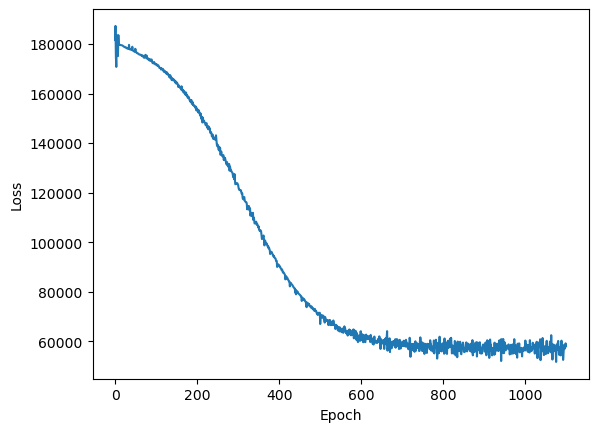

Train Error:  92705.89


In [229]:
# train the model
train_error = rbm_0.train(x_train, batch_size=32, lr=0.001, epochs=50, stop_after_epoch=3)
print("Train Error: ", train_error)

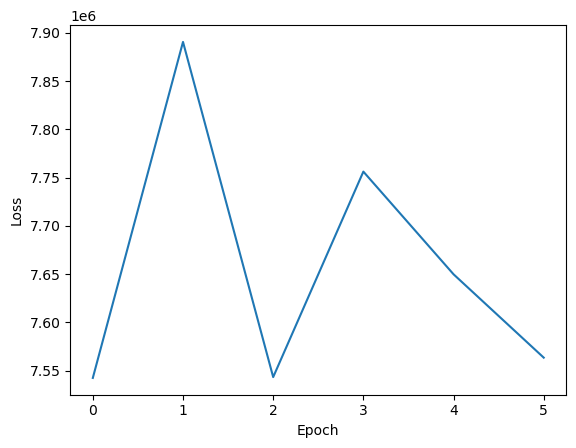

Test Error:  7657641.5


In [230]:
# test the model on the test set
test_error = rbm_0.test(x_test, batch_size=BATCH_SIZE)
print("Test Error: ", test_error)

In [231]:
def fill_road_texture(mask, background_color, texture):
    height, width, _ = mask.shape
    result = np.zeros((height, width))
    bh, bw = texture.shape
    for y in range(0, height - bh, bh):
        for x in range(0, width - bw, bw):
            result[y:(y + bh), x:(x + bw)] = texture * 255
    for y in range(0, height):
        for x in range(0, width):
            if mask[y][x] == background_color:
                result[y][x] = 0

    return result

def show_image_pairs(a, b, n):
    for i in range(0, n):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(a[i], cmap='gray')
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.imshow(b[i], cmap='gray')

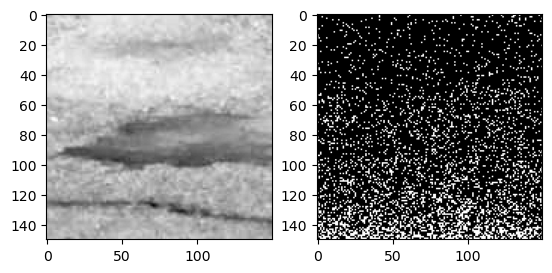

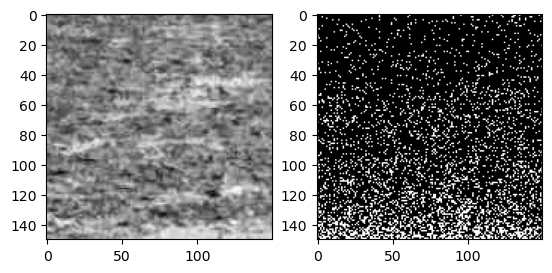

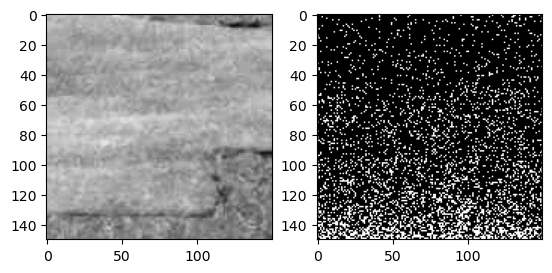

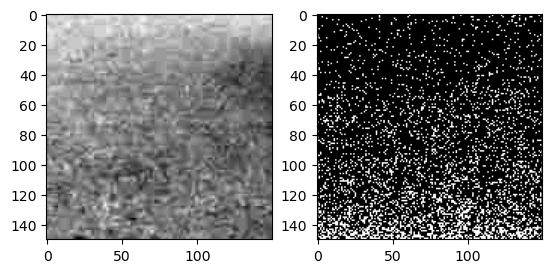

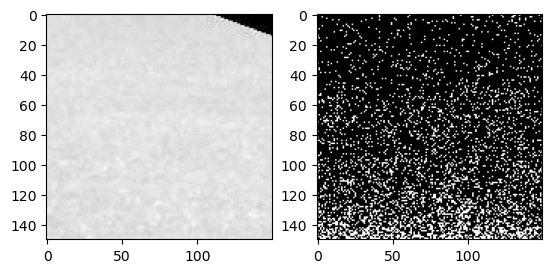

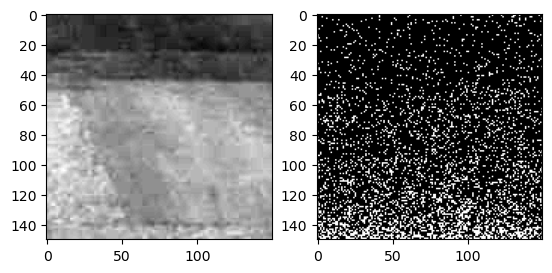

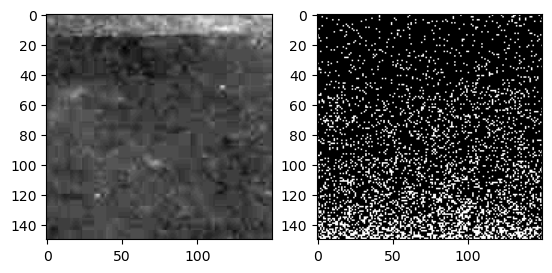

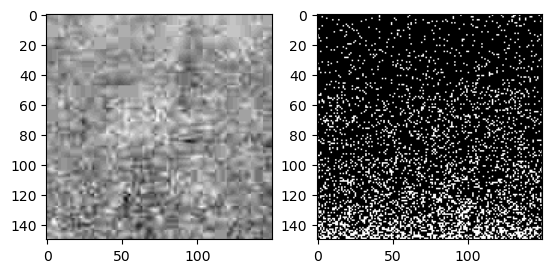

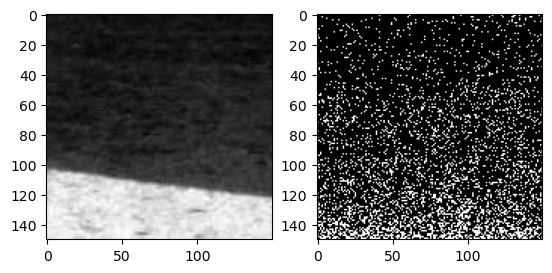

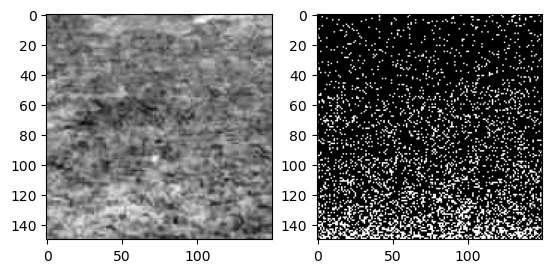

In [232]:
# verify the model on a few sample data from the test set
nr_samples = 10
# generate nr_samples random indices to select a sample subset from the test set
rand_indices = np.random.choice(x_test.shape[0], nr_samples, replace=False)
# flatten the image data (matrix of pixels) to a 1D array (feature vector)
rand_samples = [x_test[i] for i in rand_indices]
rand_samples = np.asarray(rand_samples)
# reconstruct the images
reconstructed_samples = []
for r in rand_samples:
    reconstructed_img = rbm_0.reconstruct(r)
    reconstructed_samples.append(reconstructed_img)
reconstructed_samples = np.asarray(reconstructed_samples)

# display the samples and the reconstructed patches
show_image_pairs(rand_samples, reconstructed_samples, nr_samples)

In [100]:
for i in range(nr_samples):
    gray = convert_to_grayscale(x_test_img[i])
    img = cv2.merge([gray, gray, gray])
    save_img(img, "output/original/test{}.jpeg".format(i))

In [101]:
# map the texture to the original road mask
results = []
smooth_results = []
i = 0
for mask, reconstructed_sample in zip(x_test_mask, reconstructed_samples):
    reconstructed_road = fill_road_texture(mask, 0, reconstructed_sample)
    results.append(reconstructed_road)
    # save_img(reconstructed_road, "output/raw/test{}.jpeg".format(i))
    # apply gaussian blur to eliminate the noise and smooth the surface texture
    blurred_img = cv2.GaussianBlur(reconstructed_road, (7, 7), 0)
    smooth_results.append(blurred_img)
    save_img(blurred_img, "output/smooth/test{}.jpeg".format(i))
    i += 1

show_image_pairs(results, smooth_results, i)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Compare the original image with the reconstructed one to identify objects on the road surface. Generate a heatmap (binary mask) using a predefined threshold to filter out noises.

In [129]:
def generate_heatmap(img, reconstructed, threshold):
    height, width, _ = img.shape
    heatmap = np.ones((height, width))
    heatmap *= 255
    gray_img = convert_to_grayscale(img)
    for y in range(height):
        for x in range(width):
            difference = np.abs(gray_img[y][x] - reconstructed[y][x])
            if reconstructed[y][x] > 0 and difference > threshold:
                heatmap[y][x] = 0

    # apply dilation
    kernel = np.ones((5, 5), np.uint8)
    heatmap = cv2.erode(heatmap, kernel, iterations=3)

    return heatmap

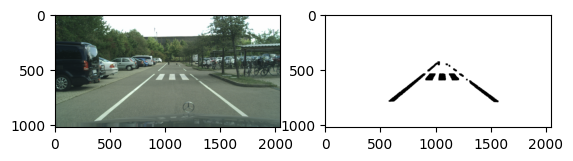

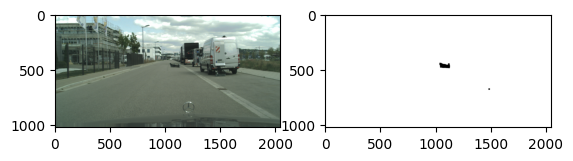

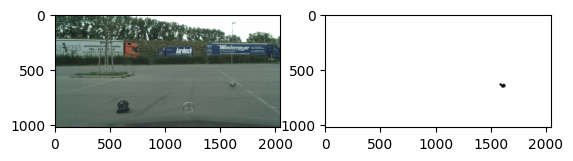

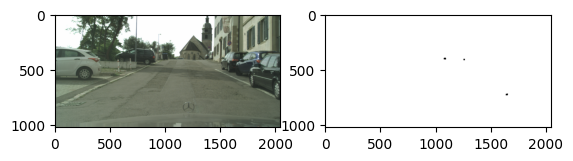

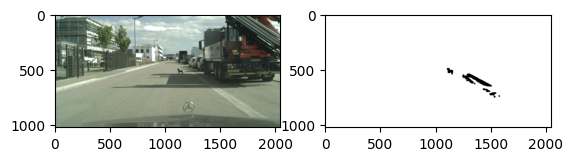

In [130]:
heatmaps = []
T = 190

i = 0
for img, reconstructed in zip(x_test_img, results):
    heatmap = generate_heatmap(img, reconstructed, T)
    heatmaps.append(heatmap)
    save_img(heatmap, "output/heatmap/test{}.jpeg".format(i))
    i += 1
    # break

show_image_pairs(x_test_img, heatmaps, i)


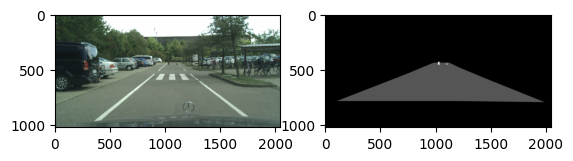

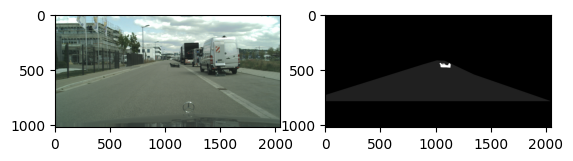

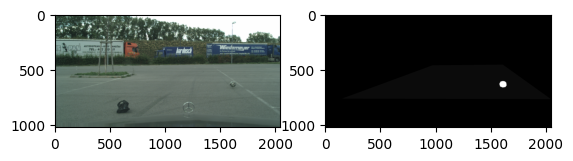

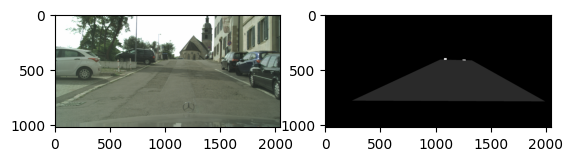

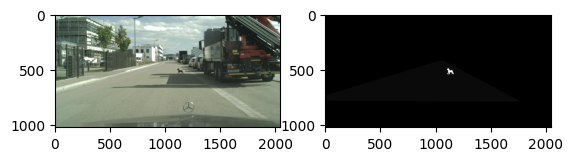

In [88]:
show_image_pairs(x_test_img, x_test_mask, 5)